# Сборный проект № 2: 

Описание проекта.

Я работаю в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. 

Необходимо изучить воронку продаж. Как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

Исследовать результаты A/A/B-эксперимента.\
Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Требуется выяснить, какой шрифт лучше.

Описание данных

Каждая запись в логе — это действие пользователя, или событие.

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная

##  Загрузка и подготовка данных к анализу

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime as dt
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import math as mth
pd.set_option('display.max_columns', 30)
pd.set_option("display.float_format", "{:.3f}".format)

In [2]:
# Загрузка данных
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [3]:
# Переименуем столбцы для удобства
data.columns = ['event_name', 'device_id_hash', 'event_time_stamp', 'exp_id']

# Проверка на пропуски и типы данных
missing_data = data.isnull().sum()
data_types = data.dtypes

# Вывод данных для проверки изменений
missing_data, data_types

(event_name          0
 device_id_hash      0
 event_time_stamp    0
 exp_id              0
 dtype: int64,
 event_name          object
 device_id_hash       int64
 event_time_stamp     int64
 exp_id               int64
 dtype: object)

In [4]:
data.head()

,event_name,device_id_hash,event_time_stamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
# Меняем формат даты
data['event_time_stamp'] = pd.to_datetime(data['event_time_stamp'], unit='s')
data.head()

,event_name,device_id_hash,event_time_stamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        244126 non-null  object        
 1   device_id_hash    244126 non-null  int64         
 2   event_time_stamp  244126 non-null  datetime64[ns]
 3   exp_id            244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


In [7]:
# Добавляем столбец даты и времени, а также отдельный столбец дат
data['datе_event'] = data['event_time_stamp'].dt.date
data.head()

,event_name,device_id_hash,event_time_stamp,exp_id,datе_event
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [8]:
#Проверим дубликаты
print(data.duplicated().sum())

413


413 дубликатов, можно их сразу удалить

In [9]:
#Проверим дубликаты
data = data.drop_duplicates().reset_index(drop=True)
print(data.duplicated().sum())

0


## Изучаем и проверяем данные

In [10]:
# Общее количество событий
total_events = data.shape[0]
total_events

243713

In [11]:
# Какие бывают события?
print(data['event_name'].nunique())
print(data['event_name'].unique())

5
['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


- 'MainScreenAppear' - Окно главной страницы сайта
- 'PaymentScreenSuccessful' - Окно "Оплата прошла успешно"
- 'CartScreenAppear' -  Окно корзины
- 'OffersScreenAppear' - Окно предложений
- 'Tutorial' - Учебное пособие

In [12]:
# Количество уникальных пользователей
total_users = data['device_id_hash'].nunique()
total_users

7551

In [13]:
# Среднее количество событий на пользователя
research_event = data.groupby('device_id_hash')['event_name'].count().reset_index()
research_event.describe()

,device_id_hash,event_name
count,7551.000,7551.000
mean,4677318727102441472.000,32.276
std,2655343100552021504.000,65.154
min,6888746892508752.000,1.000
25%,2397700422051031552.000,9.000
50%,4688021588771745792.000,20.000
75%,7007352523282521088.000,37.000
max,9222603179720523776.000,2307.000


In [14]:
np.percentile(research_event['event_name'], [90, 95, 99])

array([ 64. ,  89. , 200.5])

Мы видим что среднее количество событий на одного человека 32, max число подозрительно 2308 событий, больше 64 событий было  у 10% процентов пользователей

In [15]:
research_event_1 = research_event[research_event['event_name'] > 200.5]
print(research_event_1.sum())

device_id_hash    4562545007601322906
event_name                      34380
dtype: int64


In [16]:
# Минимальная и максимальная даты
min_date = data['event_time_stamp'].min()
max_date = data['event_time_stamp'].max()
difference = max_date-min_date
print(f'Данные от {min_date} до {max_date}, разница в {difference}.')

Данные от 2019-07-25 04:43:36 до 2019-08-07 21:15:17, разница в 13 days 16:31:41.


In [17]:
cont_event_date = data.groupby('datе_event')['device_id_hash'].count().reset_index()
cont_event_date

,datе_event,device_id_hash
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


In [18]:
cont_event_date['percent'] = cont_event_date['device_id_hash']/cont_event_date['device_id_hash'].sum()*100
cont_event_date

,datе_event,device_id_hash,percent
0,2019-07-25,9,0.004
1,2019-07-26,31,0.013
2,2019-07-27,55,0.023
3,2019-07-28,105,0.043
4,2019-07-29,184,0.075
5,2019-07-30,412,0.169
6,2019-07-31,2030,0.833
7,2019-08-01,36141,14.829
8,2019-08-02,35554,14.588
9,2019-08-03,33282,13.656


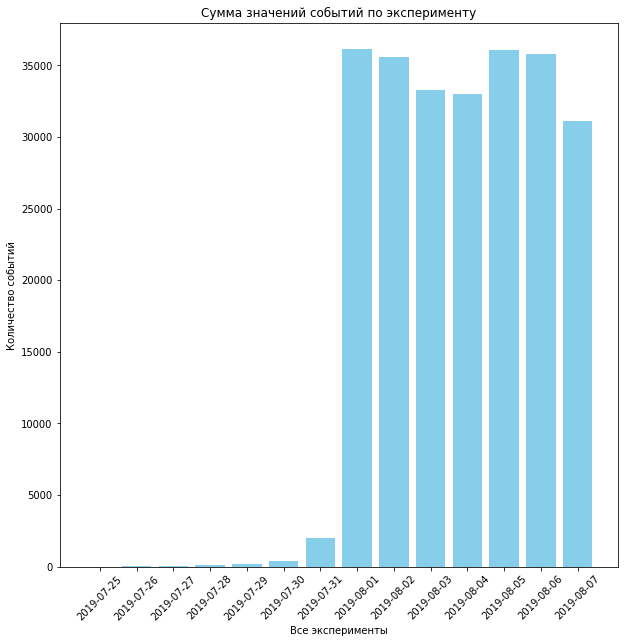

In [19]:
plt.figure(figsize=(10, 10))
plt.bar(cont_event_date['datе_event'].astype(str), cont_event_date['device_id_hash'], color='skyblue')
plt.title('Сумма значений событий по эксперименту')
plt.xlabel('Все эксперименты')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)

plt.show()

In [20]:
exp_id_246 = data[data['exp_id'] == 246]
exp_id_247 = data[data['exp_id'] == 247]
exp_id_248 = data[data['exp_id'] == 248]

In [21]:
cont_event_date_246 = exp_id_246.groupby('datе_event')['device_id_hash'].count().reset_index()
cont_event_date_246

,datе_event,device_id_hash
0,2019-07-25,4
1,2019-07-26,14
2,2019-07-27,24
3,2019-07-28,33
4,2019-07-29,55
5,2019-07-30,129
6,2019-07-31,620
7,2019-08-01,11561
8,2019-08-02,10946
9,2019-08-03,10575


In [22]:
cont_event_date['percent'] = cont_event_date['device_id_hash']/cont_event_date['device_id_hash'].sum()
cont_event_date

,datе_event,device_id_hash,percent
0,2019-07-25,9,0.000
1,2019-07-26,31,0.000
2,2019-07-27,55,0.000
3,2019-07-28,105,0.000
4,2019-07-29,184,0.001
5,2019-07-30,412,0.002
6,2019-07-31,2030,0.008
7,2019-08-01,36141,0.148
8,2019-08-02,35554,0.146
9,2019-08-03,33282,0.137


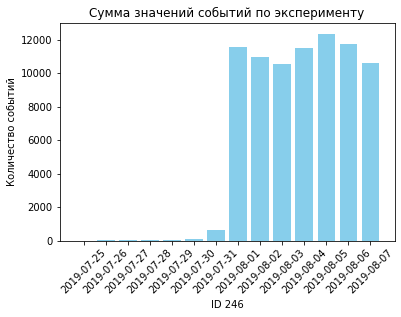

In [23]:
# Построение диаграммы
plt.bar(cont_event_date_246['datе_event'].astype(str), cont_event_date_246['device_id_hash'], color='skyblue')


plt.title('Сумма значений событий по эксперименту')
plt.xlabel('ID 246')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)

plt.show()

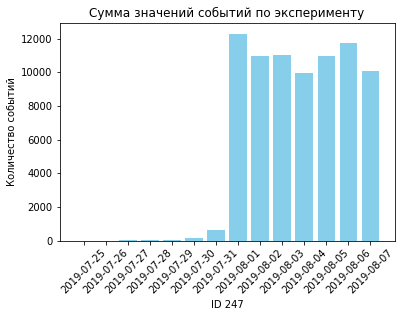

In [24]:
cont_event_date_247 = exp_id_247.groupby('datе_event')['device_id_hash'].count().reset_index()
plt.bar(cont_event_date_247['datе_event'].astype(str), cont_event_date_247['device_id_hash'], color='skyblue')


plt.title('Сумма значений событий по эксперименту')
plt.xlabel('ID 247')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)

plt.show()

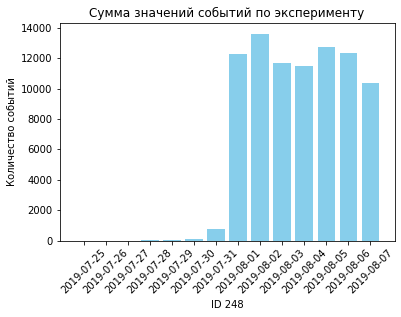

In [25]:
cont_event_date_248 = exp_id_248.groupby('datе_event')['device_id_hash'].count().reset_index()
plt.bar(cont_event_date_248['datе_event'].astype(str), cont_event_date_248['device_id_hash'], color='skyblue')

plt.title('Сумма значений событий по эксперименту')
plt.xlabel('ID 248')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)

plt.show()

Исходя из графиков,мы видим что кодичество данных не равномерно, а до 31.07.2019 количество событий не превышает 1000.

При подготовке данных для дальнейшего анализа лучше убрать события до 01.08.2019 ( что составит меньше 1%).
Так же убрать пользователя у которого больше 2000 событий

In [26]:
data.shape[0]

243713

In [27]:
# Преобразуем столбец в тип datetime
data['datе_event'] = pd.to_datetime(data['datе_event'])

df_clean = data

# Фильтрация данных
df_clean = df_clean.loc[df_clean['datе_event'] > '2019-07-31']
min_date = df_clean['event_time_stamp'].min()
max_date = df_clean['event_time_stamp'].max()
difference = max_date-min_date
print(f'Данные от {min_date} до {max_date}, разница в {difference}.')

Данные от 2019-08-01 00:07:28 до 2019-08-07 21:15:17, разница в 6 days 21:07:49.


In [28]:
df_clean.shape[0]

240887

In [29]:
a = research_event[research_event['event_name'] < 2000]
a

,device_id_hash,event_name
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137
...,...,...
7546,9217594193087726423,9
7547,9219463515465815368,17
7548,9220879493065341500,7
7549,9221926045299980007,7


In [30]:
df_clean = df_clean.loc[df_clean['device_id_hash'].isin(a['device_id_hash'])]
research_event = df_clean.groupby('device_id_hash')['event_name'].count().reset_index()
research_event.describe()

,device_id_hash,event_name
count,7533.000,7533.000
mean,4675582907402660864.000,31.671
std,2655275802871305216.000,59.582
min,6888746892508752.000,1.000
25%,2396595853709742080.000,9.000
50%,4686234251836077056.000,19.000
75%,7007003297763794944.000,37.000
max,9222603179720523776.000,1996.000


In [31]:
df_clean.shape[0]

238580

Посмотрим, сколько событий и пользователей мы потеряли, отбросив данные


In [32]:
# Количество событий до и после очистки
total_events_before_cleaning = data.shape[0]
total_events_after_cleaning = df_clean.shape[0]

# Подсчет потерянных событий
lost_events = total_events_before_cleaning - total_events_after_cleaning

# Расчет процента потерянных событий
percentage_lost_events = (lost_events / total_events_before_cleaning * 100)

# Вывод информации о потерянных данных по событиям
print(f'БЕЗ ЧИСТКИ: Всего событий {total_events_before_cleaning}, типов событий {data["event_name"].nunique()}. ')
print(f'ПОСЛЕ ЧИСТКИ: Всего событий {total_events_after_cleaning}, типов событий {df_clean["event_name"].nunique()}. ')
print(f'ПОТЕРЯНО СОБЫТИЙ: {lost_events} событий.')
print(f'ПРОЦЕНТ ПОТЕРЯННЫХ СОБЫТИЙ: {percentage_lost_events:.2f}%.')

БЕЗ ЧИСТКИ: Всего событий 243713, типов событий 5. 
ПОСЛЕ ЧИСТКИ: Всего событий 238580, типов событий 5. 
ПОТЕРЯНО СОБЫТИЙ: 5133 событий.
ПРОЦЕНТ ПОТЕРЯННЫХ СОБЫТИЙ: 2.11%.


In [33]:
# Количество пользователей до и после очистки
total_users_before_cleaning = data['device_id_hash'].nunique()
total_users_after_cleaning = df_clean['device_id_hash'].nunique()

# Подсчет потерянных пользователей
lost_users = total_users_before_cleaning - total_users_after_cleaning

# Расчет процента потерянных пользователей
percentage_lost_users = (lost_users / total_users_before_cleaning * 100)

# Вывод информации о потерянных данных по пользователям
print(f"БЕЗ ЧИСТКИ: Всего пользователей в логе {data['device_id_hash'].nunique()}.")
print(f"ПОСЛЕ ЧИСТКИ: Всего пользователей в логе {df_clean['device_id_hash'].nunique()}.")
print(f"ПОТЕРЯНО ПОЛЬЗОВАТЕЛЕЙ: {lost_users} пользователей.")
print(f"ПРОЦЕНТ ПОТЕРЯННЫХ ПОЛЬЗОВАТЕЛЕЙ: {percentage_lost_users:.2f}%.")

БЕЗ ЧИСТКИ: Всего пользователей в логе 7551.
ПОСЛЕ ЧИСТКИ: Всего пользователей в логе 7533.
ПОТЕРЯНО ПОЛЬЗОВАТЕЛЕЙ: 18 пользователей.
ПРОЦЕНТ ПОТЕРЯННЫХ ПОЛЬЗОВАТЕЛЕЙ: 0.24%.


In [34]:
# Среднее количество событий на пользователя до и после очистки
avg_events_per_user_before = data.shape[0] / data['device_id_hash'].nunique()
avg_events_per_user_after = df_clean.shape[0] / df_clean['device_id_hash'].nunique()


absolute_change_avg_events = avg_events_per_user_before - avg_events_per_user_after

# Относительное изменение среднего количества событий на пользователя в процентах
percentage_change_avg_events = (absolute_change_avg_events / avg_events_per_user_before * 100)

# Вывод информации об абсолютных и относительных потерях
print(f"БЕЗ ЧИСТКИ: В среднем событий на пользователя {avg_events_per_user_before:.2f}.")
print(f"ПОСЛЕ ЧИСТКИ: В среднем событий на пользователя {avg_events_per_user_after:.2f}.")
print(f"ПОТЕРЯ СРЕДНЕГО КОЛИЧЕСТВА СОБЫТИЙ НА ПОЛЬЗОВАТЕЛЯ: {absolute_change_avg_events:.2f}.")
print(f"ПРОЦЕНТ ПОТЕРИ СРЕДНЕГО КОЛИЧЕСТВА СОБЫТИЙ НА ПОЛЬЗОВАТЕЛЯ: {percentage_change_avg_events:.2f}%.")



БЕЗ ЧИСТКИ: В среднем событий на пользователя 32.28.
ПОСЛЕ ЧИСТКИ: В среднем событий на пользователя 31.67.
ПОТЕРЯ СРЕДНЕГО КОЛИЧЕСТВА СОБЫТИЙ НА ПОЛЬЗОВАТЕЛЯ: 0.60.
ПРОЦЕНТ ПОТЕРИ СРЕДНЕГО КОЛИЧЕСТВА СОБЫТИЙ НА ПОЛЬЗОВАТЕЛЯ: 1.87%.


Максимум 2%, это приемлемый процент потери данных

In [35]:
# Проверим, есть ли у нас пользователи из всех трёх экспериментальных групп.
print(df_clean.groupby('exp_id').agg({'device_id_hash': 'nunique'}))

        device_id_hash
exp_id                
246               2484
247               2513
248               2536


Пользователи есть в трех группах и их количество примерно одинаково

## Изучаем воронку событий

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [36]:
event_name_count = df_clean.groupby('event_name')['event_time_stamp'].count().sort_values()
event_name_count.head()

event_name
Tutorial                     1005
PaymentScreenSuccessful     32833
CartScreenAppear            41203
OffersScreenAppear          46257
MainScreenAppear           117282
Name: event_time_stamp, dtype: int64

Всего 5 событий, перечислим по мере встречаемости:

1. 'MainScreenAppear' - Окно главной страницы сайта
2. 'OffersScreenAppear' - Окно предложений
3. 'CartScreenAppear' - Окно корзины
4. 'PaymentScreenSuccessful' - Окно "Оплата прошла успешно"
5. 'Tutorial' - Учебное пособие
 

Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие

In [37]:
users_per_event = df_clean.groupby('event_name')['device_id_hash'].nunique().sort_values()
users_per_event

event_name
Tutorial                    840
PaymentScreenSuccessful    3538
CartScreenAppear           3733
OffersScreenAppear         4592
MainScreenAppear           7418
Name: device_id_hash, dtype: int64

In [38]:
# Доля пользователей, совершивших каждое событие
user_share_per_event = users_per_event / df_clean['device_id_hash'].nunique()
user_share_per_event

event_name
Tutorial                  0.112
PaymentScreenSuccessful   0.470
CartScreenAppear          0.496
OffersScreenAppear        0.610
MainScreenAppear          0.985
Name: device_id_hash, dtype: float64

Теперь расположим по убыванию количествыа пользователей:

1. 'MainScreenAppear' - Окно главной страницы сайта
2. 'OffersScreenAppear' - Окно предложений
3. 'CartScreenAppear' - Окно корзины
4. 'PaymentScreenSuccessful' - Окно "Оплата прошла успешно"
5. 'Tutorial' - Учебное пособие
    
Я предпологаю, что так и будет выглядеть воронка, кроме  последнего события. К инструкции пользователь может перейти на любом этапе, когда ему что то не понятно   

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [39]:
 # сгруппируем таблицу по событиям
event_users = df_clean.groupby('event_name').agg({'device_id_hash':'nunique'}).reset_index()
event_users.set_axis(['event_name', 'users_count'], axis='columns', inplace=True)

# добавитим столбец - какая доля уникальных пользователей совершала это событие
event_users['%'] = event_users.users_count / df_clean['device_id_hash'].nunique()
event_users = event_users.sort_values('users_count', ascending=False).reset_index(drop=True)

# построим воронку
event_users['funnel'] = 1
for i in range(1, 4):
    event_users.loc[i, 'funnel'] = event_users.loc[i, 'users_count'] /  (event_users.loc[i-1, 'users_count'])

event_users

,event_name,users_count,%,funnel
0,MainScreenAppear,7418,0.985,1.000
1,OffersScreenAppear,4592,0.610,0.619
2,CartScreenAppear,3733,0.496,0.813
3,PaymentScreenSuccessful,3538,0.470,0.948
4,Tutorial,840,0.112,1.000


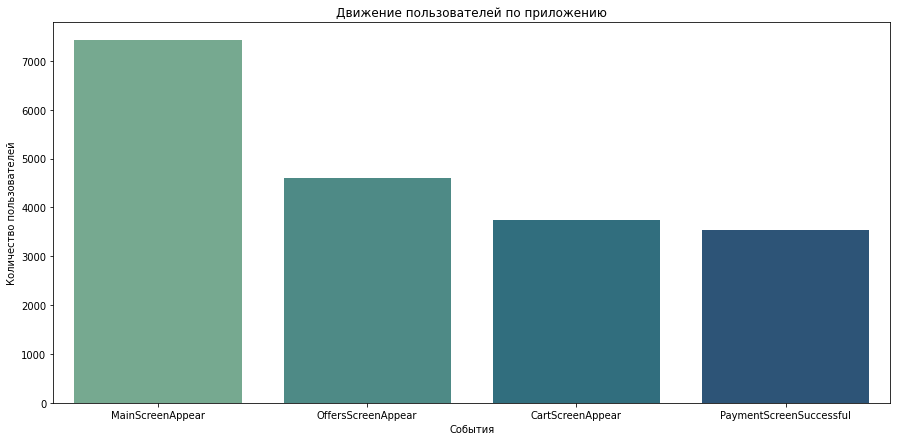

In [40]:
plt.figure(figsize=(15, 7))
sns.barplot(data=event_users.loc[0:3], x='event_name', y='users_count', palette='crest')
plt.title('Движение пользователей по приложению')
plt.xlabel('События')
plt.ylabel('Количество пользователей')
plt.show()

Мы видим, что большая часть пользователей теряется на этапе перехода с основной страницу, на страницу с предложением, около 40%. Дальше по ворнке пользователи идут более менее плавно. Оплату совершили 47% пользователей

## Изучим результаты эксперимента

In [41]:
users = df_clean.groupby('exp_id')['device_id_hash'].nunique()
users

exp_id
246    2484
247    2513
248    2536
Name: device_id_hash, dtype: int64

Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами ( 246 - 2483 пользователя, 247 - 2513 пользователей) и одну экспериментальную — с новыми ( группа 248 - 2536 пользователя)

Проверим корректность всех механизмов и расчётов. Находят ли статистические критерии разницу между выборками 246 и 247.

Критерии успешного A/A теста:
 - Количество пользователей в различных группах различается не более, чем на 1%;
 - Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
 - Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
 - Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

In [42]:
# разница в количестве пользователей
for i in range(0, 3):
    gr_list = [246, 247, 248, 246]
    print(f'Разница между группой {gr_list[i]} и {gr_list[i+1]} составляет {1 - df_clean.query("exp_id == @gr_list[@i]")["device_id_hash"].nunique() / df_clean.query("exp_id == @gr_list[@i+1]")["device_id_hash"].nunique():.2%}')

Разница между группой 246 и 247 составляет 1.15%
Разница между группой 247 и 248 составляет 0.91%
Разница между группой 248 и 246 составляет -2.09%


Процент примерно одинаковый.

In [43]:
# распределение пользователей по группам
len(df_clean.groupby('device_id_hash')['exp_id'].nunique().reset_index().query('exp_id > 1'))

0

Попавший в одну из групп посетитель остаётся в этой группе до конца теста.( общих нет)

Проверим различие ключевых метрик. Для каждого события подсчитаем, какая доля пользователей в каждой группе его совершила, и проверим, является ли отличие между группами статистически достоверным.

In [44]:
all_funnels = df_clean.pivot_table(index='event_name', columns='exp_id',values='device_id_hash',aggfunc='nunique')\
                       .sort_values(246,ascending=False)
all_funnels['246+247'] = all_funnels[246] + all_funnels[247]
all_funnels.drop(['Tutorial'], inplace=True)
all_funnels

exp_id,246,247,248,246+247
event_name,,,,
MainScreenAppear,2450,2476,2492,4926
OffersScreenAppear,1542,1520,1530,3062
CartScreenAppear,1266,1238,1229,2504
PaymentScreenSuccessful,1200,1158,1180,2358


In [45]:
users = users.to_frame().reset_index()
users.loc[3] = ['246+247', 4997]

In [46]:
users = users.set_index(users.columns[0])
users

,device_id_hash
exp_id,
246,2484
247,2513
248,2536
246+247,4997


In [47]:
# Воспользуемся Z-критерием
def z_test(exp1, exp2, event, alpha): 
    p1_ev = all_funnels.loc[event, exp1]
    p2_ev = all_funnels.loc[event, exp2] 
    p1_us = users.loc[exp1, 'device_id_hash'] 
    p2_us = users.loc[exp2, 'device_id_hash'] 
    p1 = p1_ev / p1_us 
    p2 = p2_ev / p2_us 
    difference = p1 - p2
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_us + 1 / p2_us))
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Проверка для  {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(exp1, exp2, event, p_value=p_value))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Сформулируем гипотезу:

Гипотеза H0: между долями нет значимой разницы

Гипотеза H1: между долями есть значимая разница

Критический уровень статистической значимости = 0,05

In [48]:
for event in all_funnels.index:
    z_test(246, 247, event, 0.05)
    print()

Проверка для  246 и 247, событие: MainScreenAppear, p-значение: 0.76
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 247, событие: OffersScreenAppear, p-значение: 0.25
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 247, событие: CartScreenAppear, p-значение: 0.23
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 247, событие: PaymentScreenSuccessful, p-значение: 0.11
Не получилось отвергнуть нулевую гипотезу



In [49]:
for event in all_funnels.index:
    z_test(246, 248, event, 0.05)
    print()

Проверка для  246 и 248, событие: MainScreenAppear, p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 248, событие: OffersScreenAppear, p-значение: 0.20
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 248, событие: CartScreenAppear, p-значение: 0.08
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 248, событие: PaymentScreenSuccessful, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу



In [50]:
for event in all_funnels.index:
    z_test('246+247', 248, event, 0.05)
    print()

Проверка для  246+247 и 248, событие: MainScreenAppear, p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу

Проверка для  246+247 и 248, событие: OffersScreenAppear, p-значение: 0.43
Не получилось отвергнуть нулевую гипотезу

Проверка для  246+247 и 248, событие: CartScreenAppear, p-значение: 0.18
Не получилось отвергнуть нулевую гипотезу

Проверка для  246+247 и 248, событие: PaymentScreenSuccessful, p-значение: 0.59
Не получилось отвергнуть нулевую гипотезу



При проверки мы увидели, что отвергнуть нулевую гипотизу не получилось.

Это значит, что между группами нет значимой разницы

Посчитаем, сколько проверок статистических гипотез мы сделали.Какой уровень значимости стоит применить?

Критический уровень статистической значимости = 0,05
В итоге мы сделали 4 AA теста и 12 AB теста

In [51]:
# Создаем DataFrame 
report = pd.DataFrame(index=[0])
report['m'] = 16  # число тестов
report['alpha'] = 0.05  # исходный уровень значимости

# Считаем поправку Бонферрони
report['alpha_bonf'] = report['alpha'] / report['m']  # расчёт откорректированного уровня значимости

# Считаем FWER по методу Бонферрони
report['fwer_bonf'] = 1 - (1 - report['alpha_bonf']) ** report['m']  # расчёт Family-Wise Error Rate

# Выводим результаты
print(report)

    m  alpha  alpha_bonf  fwer_bonf
0  16  0.050       0.003      0.049


Для коррекции уровня значимости мы использовали Метод Бонферрони, он показал, что a =  0.003. Но это не приведет изменениям в оценки гипотизы, так как самое меньшее p-значение: 0.08, что уже больше 0,05. 

Следовательно, нулевую гипотезу не удалось отвергнуть, и шрифт не влияет на взаимодействие пользователя с приложением

Вывод

В ходе исследования мобильного приложения магазина продуктов мы проанализировали данные, полученные в эксперименте. Нулевая гипотеза, предполагающая, что выбранный шрифт не влияет на взаимодействие пользователей, не была опровергнута, что может означать, что новый шрифт также удобен, как и старый.